<a href="https://colab.research.google.com/github/Senuth-Per/ML_Coursework_Banking_Systerm/blob/main/Ml_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Shape: (41188, 21)

Missing Values (count of 'unknown'):
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Data Types:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


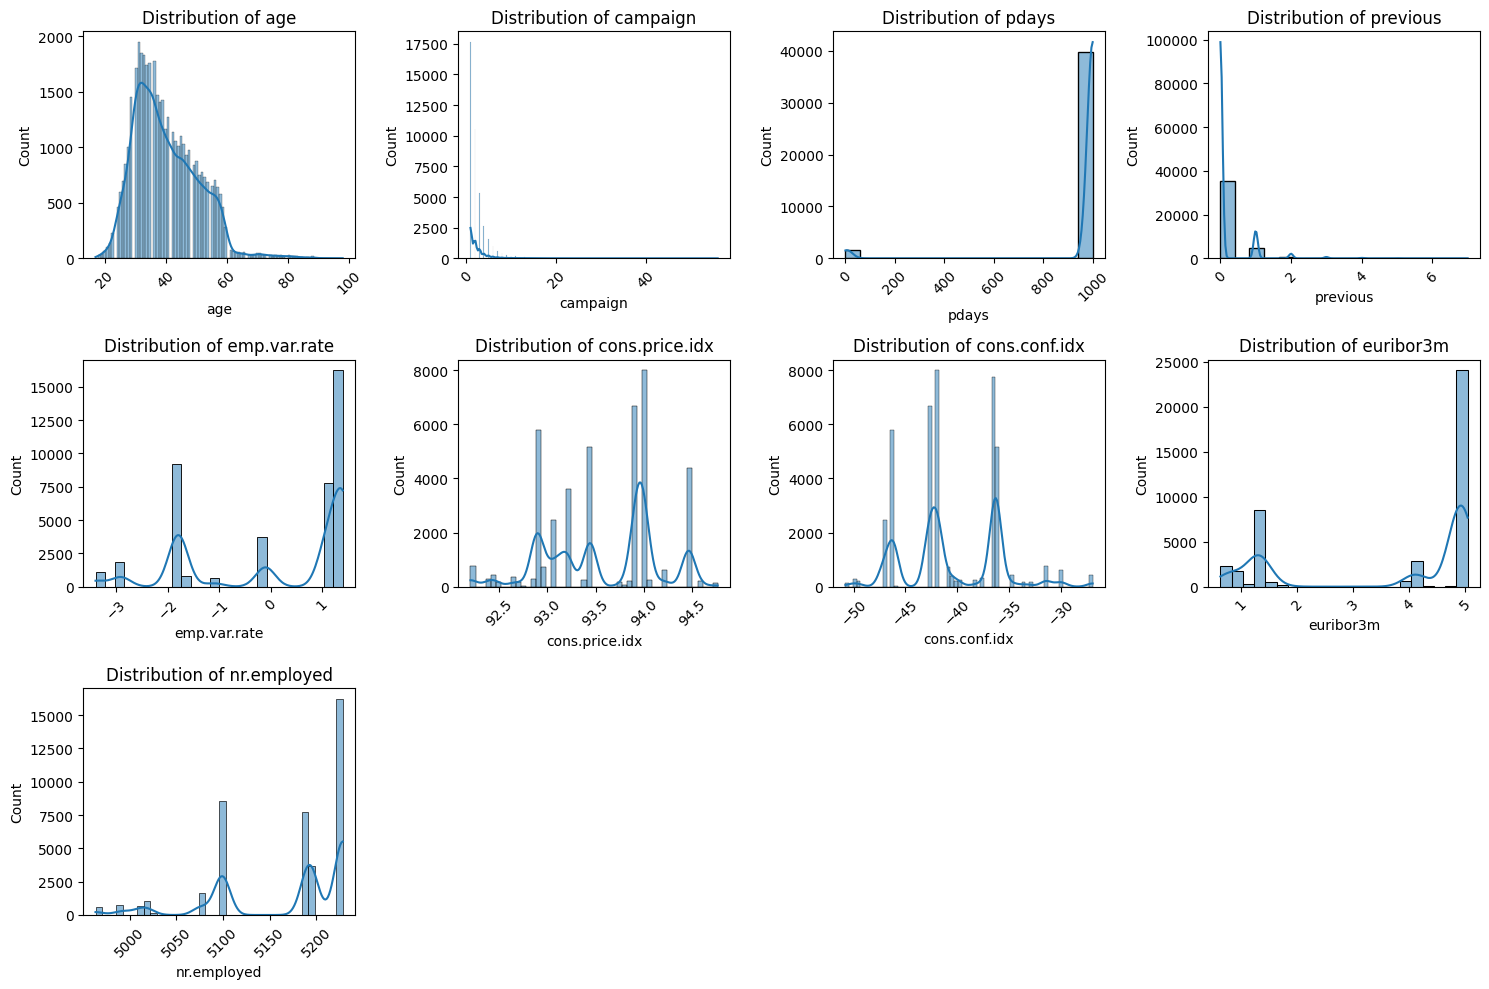

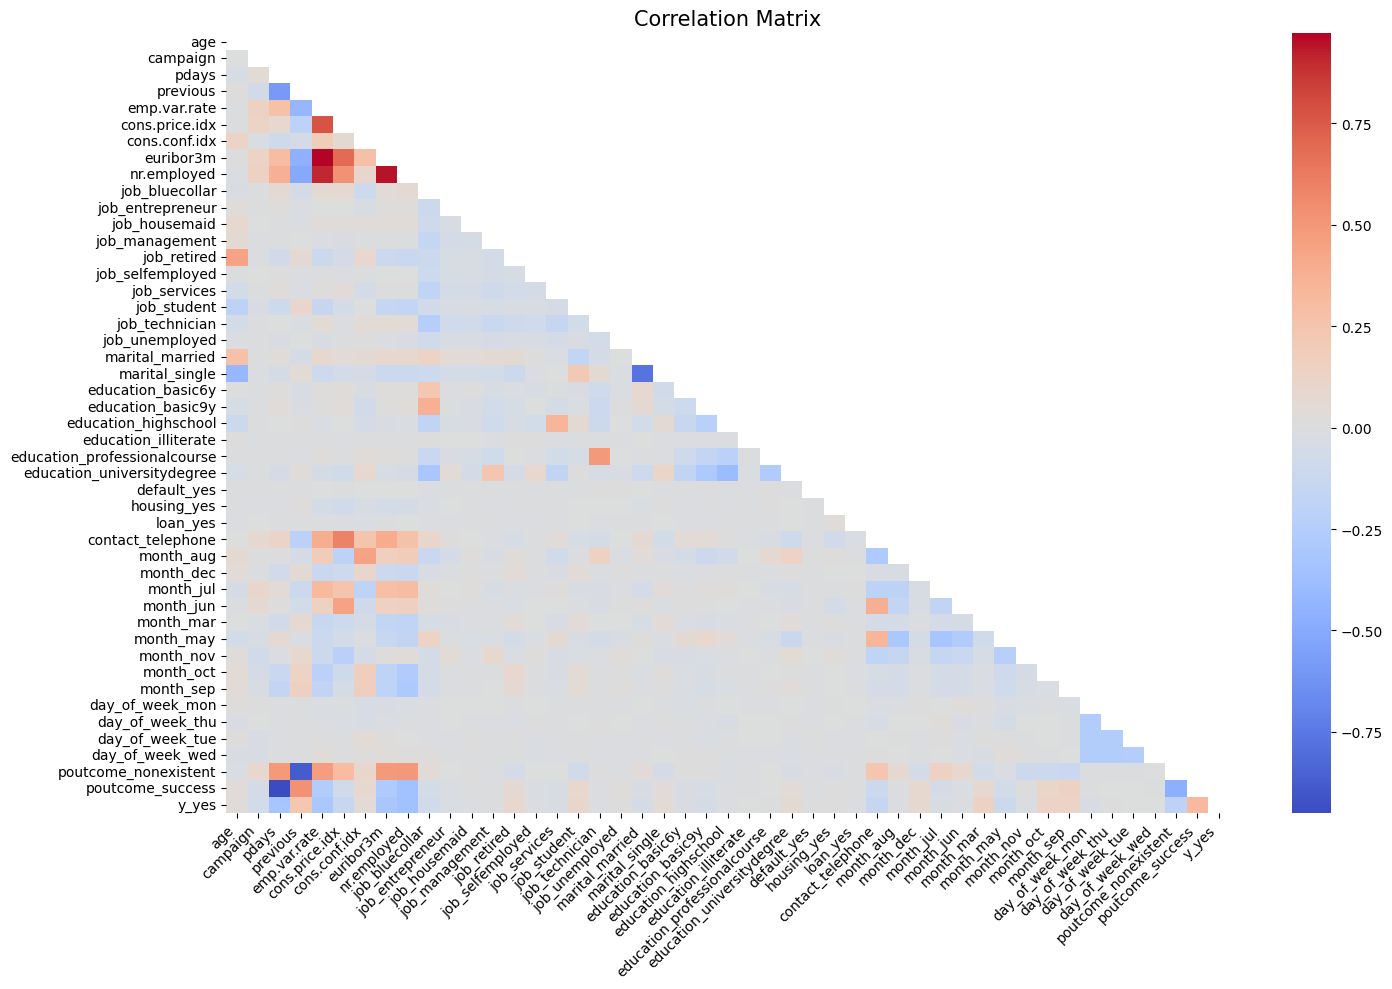


Final dataset shapes:
X_train shape: (58459, 46)
X_test shape: (14615, 46)
y_train shape: (58459,)
y_test shape: (14615,)


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Load the dataset from the specified file path
file_path = "/content/drive/MyDrive/Colab Notebooks/bank-additional-full.csv"
# Read the CSV file using semicolon as separator
df = pd.read_csv(file_path, sep=';')

# Function to display basic dataset information
def dataset_info(df):
    print("Dataset Shape:", df.shape)  # Print the shape of the dataset (rows, columns)
    print("\nMissing Values (count of 'unknown'):")
    print((df == 'unknown').sum())  # Count and display the number of 'unknown' values in each column
    print("\nData Types:")
    print(df.dtypes)  # Display the data types of each column


dataset_info(df)

# Remove duplicate rows from the dataset
print(f"Number of duplicate rows: {df.duplicated().sum()}")  # Print the count of duplicate rows
df = df.drop_duplicates()  # Drop duplicate rows from the DataFrame

# Function to handle 'unknown' values in the dataset
def handle_unknown_values(df):
    # Replace 'unknown' with NaN for easier processing
    df = df.replace('unknown', np.nan)

    # Separate categorical and numerical columns for imputation
    categorical_columns = df.select_dtypes(include=['object']).columns  # Identify categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns  # Identify numerical columns

    # Impute categorical columns with mode (most frequent value)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

    # Impute numerical columns with median value
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_columns] = num_imputer.fit_transform(df[numerical_columns])

    return df  # Return the cleaned DataFrame

# Function to remove punctuation from categorical columns
def remove_punctuation_from_categorical(df):
    categorical_columns = df.select_dtypes(include=['object']).columns  # Identify categorical columns
    df[categorical_columns] = df[categorical_columns].replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    return df

# Clean the dataset by handling unknown values and removing punctuation
df_cleaned = handle_unknown_values(df.copy())
df_cleaned = remove_punctuation_from_categorical(df_cleaned)

# Function to encode categorical variables using one-hot encoding
def encode_categorical_variables(df):
    categorical_columns = df.select_dtypes(include=['object']).columns  # Identify categorical columns
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)  # One-hot encode categorical variables, dropping first to avoid dummy variable trap
    return df  # Return the encoded DataFrame

# Encode categorical variables in the cleaned DataFrame
df_encoded = encode_categorical_variables(df_cleaned.copy())

# Function to scale numerical variables using StandardScaler
def scale_numerical_variables(df):
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns  # Identify numerical columns
    scaler = StandardScaler()  # Initialize StandardScaler for normalization
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])  # Scale numerical features to have mean=0 and variance=1
    return df  # Return the scaled DataFrame

# Scale numerical variables in the encoded DataFrame
df_scaled = scale_numerical_variables(df_encoded.copy())

# Handle the 'duration' feature by removing it from the dataset for predictive modeling purposes (as per guidelines)
if 'duration' in df_scaled.columns:
    df_scaled = df_scaled.drop('duration', axis=1)  # Drop 'duration' column

# Function to detect outliers based on IQR (Interquartile Range) method
def detect_outliers(df):
    outlier_summary = {}  # Dictionary to store outlier information for each column
    for col in df.select_dtypes(include=['float64', 'int64']).columns:  # Iterate over numerical columns
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

        # Detect outliers where values are less than lower_bound or greater than upper_bound
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Store the outlier count and bounds for each column
        outlier_summary[col] = {
            'outlier_count': outliers.shape[0],
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return outlier_summary  # Return the outlier summary

# Function to display the outlier summary
def display_outlier_summary(outlier_summary):
    for col, summary in outlier_summary.items():
        print(f"Column: {col}")
        print(f"  - Outlier Count: {summary['outlier_count']}")
        print(f"  - Lower Bound: {summary['lower_bound']}")
        print(f"  - Upper Bound: {summary['upper_bound']}")
        print("")

# Function to handle (cap) outliers using IQR-based capping method
def cap_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:  # Iterate over numerical columns
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound for capping
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for capping

        # Cap values below lower bound to the lower bound
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

        # Cap values above upper bound to the upper bound
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df  # Return the DataFrame with capped outliers

# Detect outliers in the scaled DataFrame
outlier_summary = detect_outliers(df_scaled)

# Display outlier summary
display_outlier_summary(outlier_summary)

# Handle (cap) outliers in the scaled DataFrame
df_scaled_capped = cap_outliers(df_scaled.copy())

# Detect outliers again after handling (capping) them
outlier_summary_after_capping = detect_outliers(df_scaled_capped)

# Display the updated outlier summary after capping
print("Outlier summary after capping:")
display_outlier_summary(outlier_summary_after_capping)

# Function to handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
def handle_class_imbalance(X, y):
    smote = SMOTE(random_state=42)  # Initialize SMOTE for oversampling
    X_resampled, y_resampled = smote.fit_resample(X, y)  # Resample the dataset to handle imbalance
    return X_resampled, y_resampled  # Return the resampled features and target variables

# Ensure that X and y are defined
X = df_scaled.drop('y_yes', axis=1)  # Features: all columns except the target variable (assuming binary encoding)
y = df_scaled['y_yes']  # Target variable: y_yes column

# Handle class imbalance
X_resampled, y_resampled = handle_class_imbalance(X, y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Function to plot distributions of numerical features using seaborn's histplot with KDE overlay
def plot_distributions(df, numerical_cols):
    plt.figure(figsize=(15, 10))  # Set figure size for plots
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(3, 4, i)  # Create a subplot for each numerical feature
        sns.histplot(data=df, x=col, kde=True)  # Plot histogram and KDE for each feature
        plt.title(f'Distribution of {col}')  # Title for each subplot
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap between subplots
    plt.show()  # Show plots

# Plot distributions for selected numerical features in the cleaned DataFrame
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
plot_distributions(df_cleaned, numerical_features)

# Function to plot a correlation matrix using seaborn's heatmap function
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()  # Calculate correlation matrix for all features

    # Plotting the correlation matrix as a heatmap
    plt.figure(figsize=(15, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle of correlation matrix for better readability
    sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)

    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
    plt.yticks(fontsize=10)

    plt.title("Correlation Matrix", fontsize=15)
    plt.tight_layout()
    plt.show()

# Plot correlation matrix for scaled features
plot_correlation_matrix(df_scaled)

# Print shapes of training and testing datasets to verify split results
print("\nFinal dataset shapes:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Save preprocessed data to CSV files
X_train.to_csv('/content/drive/MyDrive/banking_system/X_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/banking_system/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/banking_system/y_train.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/banking_system/y_test.csv', index=False)




In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve,
                             classification_report)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load preprocessed data from CSV files into DataFrames
X_train = pd.read_csv('/content/drive/MyDrive/banking_system/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/banking_system/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/banking_system/y_train.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/banking_system/y_test.csv').squeeze()

# Function to evaluate and display metrics for model performance
def evaluate_model(y_true, y_pred, y_proba):
    # Calculate various evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)  # Calculate accuracy of the model
    precision = precision_score(y_true, y_pred)  # Calculate precision of the model
    recall = recall_score(y_true, y_pred)  # Calculate recall of the model
    f1 = f1_score(y_true, y_pred)  # Calculate F1 score of the model
    auc_roc = roc_auc_score(y_true, y_proba)  # Calculate AUC-ROC score

    # Print evaluation results in a formatted manner (rounded to five decimal places)
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1-score: {f1:.5f}")
    print(f"AUC-ROC: {auc_roc:.5f}")

    # Return all calculated metrics as a dictionary for further use
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }




Random Forest Results:
Accuracy: 0.87725
Precision: 0.89551
Recall: 0.85262
F1-score: 0.87354
AUC-ROC: 0.95141


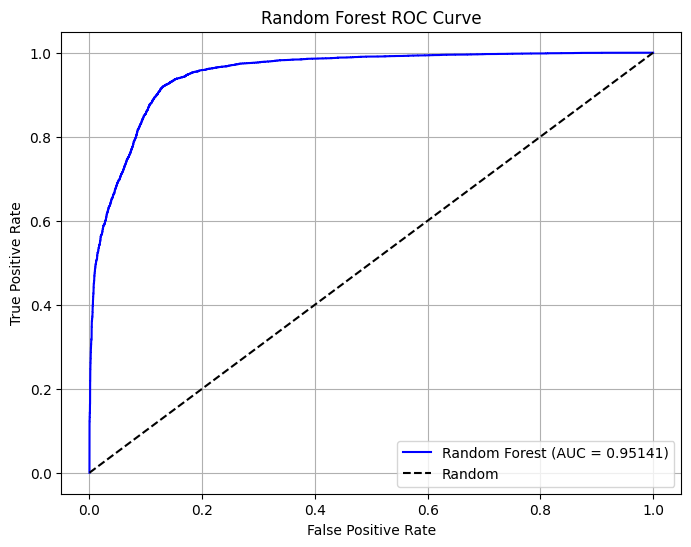

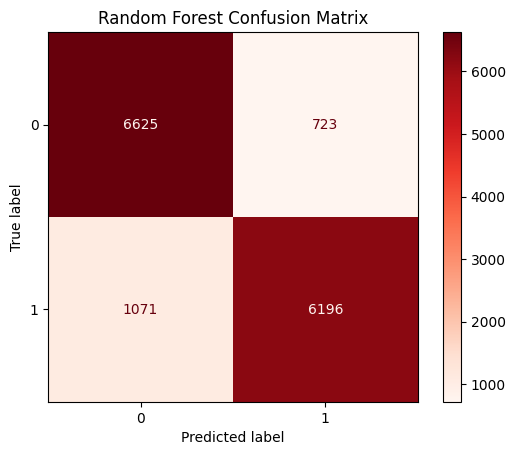


Classification Report (Random Forest):
              precision    recall  f1-score   support

       False       0.86      0.90      0.88      7348
        True       0.90      0.85      0.87      7267

    accuracy                           0.88     14615
   macro avg       0.88      0.88      0.88     14615
weighted avg       0.88      0.88      0.88     14615


Training Accuracy: 0.90578
Testing Accuracy: 0.87725


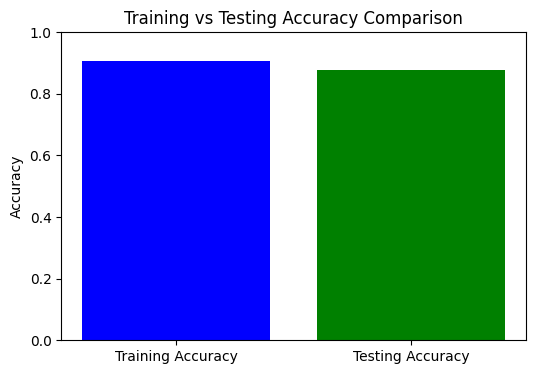

In [18]:
# Import the RandomForestClassifier from sklearn's ensemble module
from sklearn.ensemble import RandomForestClassifier

# Function to train and evaluate a Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    # Initialize the Random Forest Classifier with specified hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=200,  # Number of trees in the forest
        max_depth=50,      # Maximum depth of each tree
        min_samples_split=10,  # Minimum number of samples required to split an internal node
        min_samples_leaf=5,    # Minimum number of samples required to be at a leaf node
        random_state=42,      # Seed for reproducibility
        max_features='log2',  # Number of features to consider for each split
        class_weight='balanced',  # Balance class weights for imbalanced datasets
        n_jobs=-1              # Use all available cores for parallel processing
    )

    # Fit the model on the training data
    rf_model.fit(X_train, y_train)

    # Predict on the test set to get class labels and predicted probabilities for the positive class
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    print("\nRandom Forest Results:")

    # Evaluate the model using a predefined function and store metrics in a dictionary
    rf_metrics = evaluate_model(y_test, y_pred_rf, y_proba_rf)

    # ROC Curve Calculation
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)  # Calculate false positive rate and true positive rate for ROC curve

    # Plotting ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Random Forest (AUC = {rf_metrics['auc_roc']:.5f})", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")  # Plot diagonal line representing random guessing
    plt.title("Random Forest ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Generate and plot confusion matrix for Random Forest model predictions
    cm_rf = confusion_matrix(y_test, y_pred_rf)  # Compute confusion matrix based on true and predicted labels
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)  # Create a display object for confusion matrix visualization
    disp_rf.plot(cmap=plt.cm.Reds)
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # Display Classification Report
    print("\nClassification Report (Random Forest):")
    print(classification_report(y_test, y_pred_rf))

    # Training Accuracy
    y_pred_train_rf = rf_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train_rf)
    print(f"\nTraining Accuracy: {train_accuracy:.5f}")

    # Testing Accuracy
    test_accuracy = accuracy_score(y_test, y_pred_rf)
    print(f"Testing Accuracy: {test_accuracy:.5f}")

    # Plot Training vs Testing Accuracy Comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
    plt.title('Training vs Testing Accuracy Comparison')
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.show()

    return rf_metrics

# Train and evaluate Random Forest model using training data and test data
rf_metrics = train_random_forest(X_train, y_train, X_test, y_test)



Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1462/1462 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7371 - loss: 0.5321 - val_accuracy: 0.7899 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 2/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7879 - loss: 0.4543 - val_accuracy: 0.8015 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 3/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7959 - loss: 0.4304 - val_accuracy: 0.8076 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 4/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8091 - loss: 0.4076 - val_accuracy: 0.8140 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 5/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8143 - loss: 0.4018 - val_accuracy: 0.8197 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 6/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8199 - loss: 0.3865 - val_accuracy: 0.8215 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 7/60
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8231 - loss: 0.3773

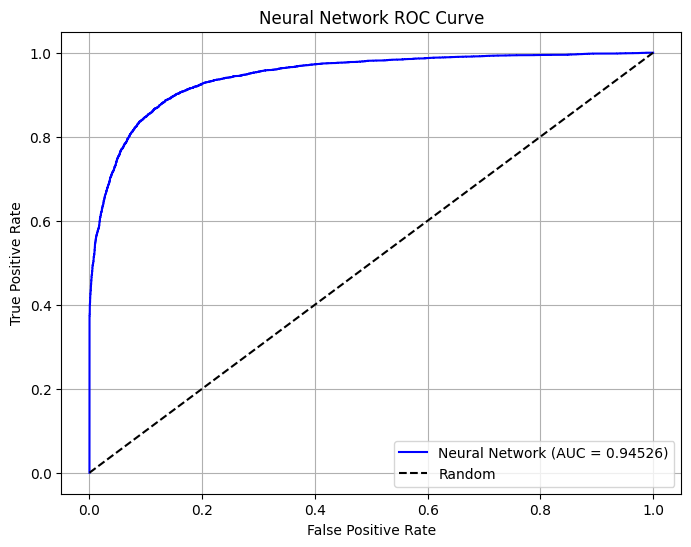

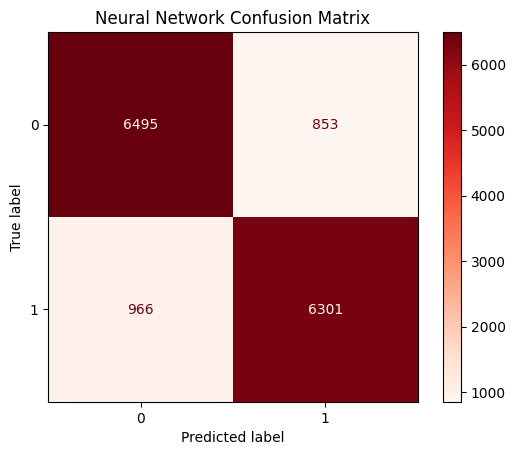

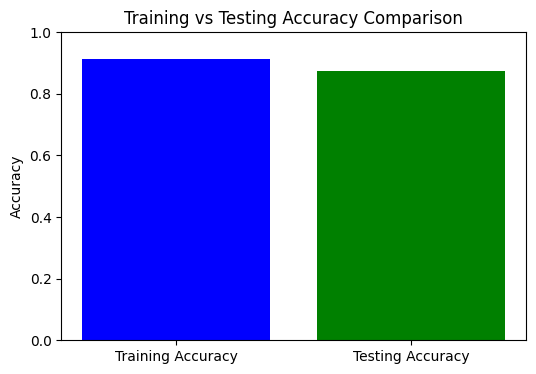

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Function to train and evaluate a Neural Network model
def train_neural_network(X_train, y_train, X_test, y_test):

    # Define the architecture of the Neural Network using Keras Sequential API
    nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 64 neurons and ReLU activation
        Dropout(0.3),  # Dropout layer with 30% dropout rate to prevent overfitting
        Dense(128, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
        Dropout(0.2),  # Dropout layer with 20% dropout rate
        Dense(64, activation='relu'),# Hidden layer with 16 neurons and ReLU activation
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification (outputting probabilities)
    ])

    # Compile the model specifying optimizer and loss function
    nn_model.compile(
        optimizer='adam',             # Adam optimizer for training
        loss='binary_crossentropy',   # Binary crossentropy loss function for binary classification
        metrics=['accuracy']          # Metric to monitor during training
    )

    # Early stopping callback to prevent overfitting by stopping training when validation loss doesn't improve
    early_stopping = EarlyStopping(
        monitor='val_loss',          # Monitor validation loss
        patience=5,                  # Stop training after 5 epochs without improvement
        restore_best_weights=True     # Restore weights from the best epoch
    )
    lrScheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the neural network with a validation split (20% of training data used for validation)
    history = nn_model.fit(
        X_train, y_train,
        epochs=60,                   # Maximum number of epochs to train
        batch_size=32,               # Number of samples per gradient update
        validation_split=0.2,       # Use 20% of training data for validation during training
        callbacks=[early_stopping,lrScheduler],   # Include early stopping callback
        verbose=1                    # Print training progress logs
    )

    # Evaluate the trained neural network on the test set
    y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32").flatten()  # Predict classes based on a threshold of 0.5
    y_proba_nn = nn_model.predict(X_test)  # Get predicted probabilities for the test set

    print("\nNeural Network Results:")
    nn_metrics = evaluate_model(y_test, y_pred_nn, y_proba_nn)  # Evaluate model performance using predefined function

    # Classification Report
    print("\nClassification Report (Neural Network):")
    print(classification_report(y_test, y_pred_nn))

    # Training Accuracy
    y_pred_train_nn = (nn_model.predict(X_train) > 0.5).astype("int32").flatten()  # Predict classes for training data
    train_accuracy = accuracy_score(y_train, y_pred_train_nn)
    print(f"\nTraining Accuracy: {train_accuracy:.5f}")

    # Testing Accuracy
    test_accuracy = accuracy_score(y_test, y_pred_nn)
    print(f"Testing Accuracy: {test_accuracy:.5f}")

    # Plot ROC Curve for Neural Network model
    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)  # Calculate false positive rate and true positive rate for ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {nn_metrics['auc_roc']:.5f})", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")  # Diagonal line representing random guessing
    plt.title("Neural Network ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Generate and plot confusion matrix for Neural Network model predictions
    cm_nn = confusion_matrix(y_test, y_pred_nn)  # Compute confusion matrix based on true and predicted labels
    disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)  # Create a display object for confusion matrix visualization
    disp_nn.plot(cmap=plt.cm.Reds)
    plt.title("Neural Network Confusion Matrix")
    plt.show()

    # Plot Training vs Testing Accuracy Comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
    plt.title('Training vs Testing Accuracy Comparison')
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.show()

    return nn_metrics

# Train and evaluate Neural Network model using training data and test data
nn_metrics = train_neural_network(X_train, y_train, X_test, y_test)


In [19]:
# Create a DataFrame to compare model performance metrics
comparison_df = pd.DataFrame({
   'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],  # List of metrics to compare
   'Random Forest': [rf_metrics['accuracy'], rf_metrics['precision'],       # Random Forest metrics
                     rf_metrics['recall'], rf_metrics['f1'], rf_metrics['auc_roc']],
   'Neural Network': [nn_metrics['accuracy'], nn_metrics['precision'],      # Neural Network metrics
                      nn_metrics['recall'], nn_metrics['f1'], nn_metrics['auc_roc']]
})

# Print the comparison DataFrame without the index for cleaner output
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))  # Display the comparison table

# Determine the best model based on AUC-ROC score
if rf_metrics['auc_roc'] > nn_metrics['auc_roc']:  # Compare AUC-ROC scores of both models
   print("Random Forest performed better.")  # Print result if Random Forest has a higher AUC-ROC score
else:
   print("Neural Network performed better.")  # Print result if Neural Network has a higher or equal AUC-ROC score




Model Comparison:
   Metric  Random Forest  Neural Network
 Accuracy       0.877249        0.875539
Precision       0.895505        0.880766
   Recall       0.852621        0.867070
 F1-Score       0.873537        0.873865
  AUC-ROC       0.951409        0.945263
Random Forest performed better.
